In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_rez = os.path.join(path2p, "data")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
import graph_lib

%load_ext autoreload
%autoreload 2

Appended library directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity/codes/lib


### Simplification for CC computation

$$
\newcommand{\larr}{\leftarrow}
\newcommand{\rarr}{\rightarrow}
\newcommand{\rlarr}{\rightleftarrows}
$$

$C^{\rlarr}_i = \sum_{u=1}^N \sum_{v=u+1}^N \sum_{w=v+1}^N S_{uvw} (\delta_{ui} + \delta_{vi} + \delta_{wi})$

$
S^{\rlarr}_{uvw}
= T_{uv, uw, vw}
+ T_{uv, uw, wv}
+ T_{uv, wu, vw}
+ T_{uv, wu, wv}
+ T_{vu, uw, vw}
+ T_{vu, uw, wv}
+ T_{vu, wu, vw}
+ T_{vu, wu, wv}
$

$T_{uv, uw, vw} = \sqrt[3]{M_{uv}M_{uw}M_{vw}}$


**Step 1:** Define intermediate variable

Define $S_{uv}^{\rlarr} = S_{uv} + S_{vu} = \sqrt[3]{M_{uv}} + \sqrt[3]{M_{vu}}$

Then $S^{\rlarr}_{uvw} = S^{\rlarr}_{uv}S^{\rlarr}_{uw}S^{\rlarr}_{vw}$

Note that $S_{uv}$ is symmetric, and thus $S_{uvw}$ is symmetric under permutation of any two indices

**Step 2:** Simplify computation of CC

$$
\begin{eqnarray}
C^{\rlarr}_i
&=& \sum_{u=1}^N \sum_{v=u+1}^N \sum_{w=v+1}^N S^{\rlarr}_{uvw} (\delta_{ui} + \delta_{vi} + \delta_{wi}) \\
&=&
\sum_{v=i+1}^N \sum_{w=v+1}^N S^{\rlarr}_{ivw}
+ \sum_{u=1}^N \sum_{w=v+1}^N S^{\rlarr}_{uiw} \delta(i > u)
+ \sum_{u=1}^N \sum_{v=u+1}^N S^{\rlarr}_{uvi} \delta(i > v) \\
&=& \sum_{u=1}^N \sum_{v=u+1}^N S^{\rlarr}_{iuv} 
= \frac{1}{2} S^{\rlarr}_{iu}S^{\rlarr}_{iv}S^{\rlarr}_{uv} 
\end{eqnarray}
$$

**Step 3:** Compute weighted normalization

The normalization for triangular weight is defined as the weight it would have if the 3rd edge had the maximal weight. Then
$$\max(S^{\rlarr}_{uv}) = 2(1 - \delta_{uv})$$
$$\max(S^{\rlarr}_{iuv}) = 2 (1 - \delta_{uv}) S^{\rlarr}_{iu} S^{\rlarr}_{iv}$$
$$\max(C^{\rlarr}_i) = \sum_{u=1}^N \sum_{v=1}^N S^{\rlarr}_{iu} S^{\rlarr}_{iv} - \sum_{u=1}^N (S^{\rlarr}_{iu})^2
= \biggl(\sum_{u=1}^N S^{\rlarr}_{iu} \biggr)^2 - \sum_{u=1}^N (S^{\rlarr}_{iu})^2 $$

The first term is the square of cubic root total degree, the second term are the contributions from degenerate triangles, where both edges of the triangle are the same.

### CC - incoming and outgoing

Analogously to the above total definition, we can define indegree and outdegree clustering coefficients
$$C^{\larr}_i = \sum_{u=1}^N \sum_{v=u+1}^N S^{\larr}_{iuv}$$
$$C^{\rarr}_i = \sum_{u=1}^N \sum_{v=u+1}^N S^{\rarr}_{iuv}$$
where the triangle weights only include two terms
$$S^{\larr}_{iuv} = T_{ui, vi, uv} + T_{ui, vi, vu} = S_{ui}S_{vi}S^{\rlarr}_{uv}$$
$$S^{\rarr}_{iuv} = T_{iu, iv, uv} + T_{iu, iv, vu} = S_{iu}S_{iv}S^{\rlarr}_{uv}$$
And the normalization can be computed as
$$\max(C^{\larr}_i) = \sum_{u=1}^N \sum_{v=1}^N S_{ui} S_{vi} - \sum_{u=1}^N S_{ui}^2
= \biggl(\sum_{u=1}^N S_{ui} \biggr)^2 - \sum_{u=1}^N S_{ui}^2 $$
$$\max(C^{\rarr}_i) = \sum_{u=1}^N \sum_{v=1}^N S_{iu} S_{iv} - \sum_{u=1}^N S_{iu}^2
= \biggl(\sum_{u=1}^N S_{iu} \biggr)^2 - \sum_{u=1}^N S_{iu}^2 $$

# Test 1. Random Matrix with increasing connectivity

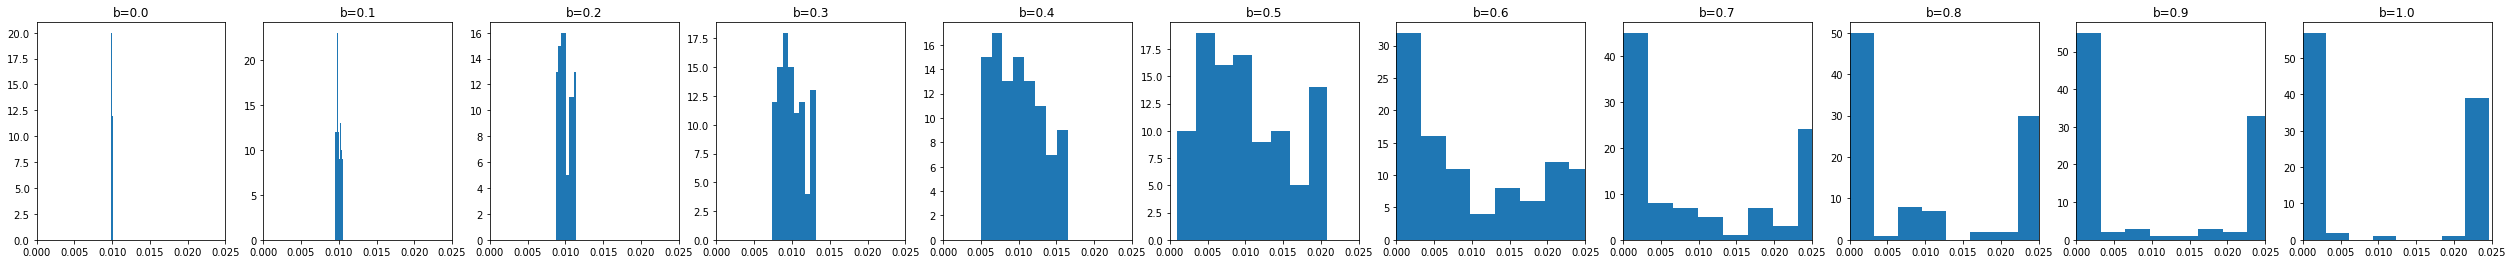

In [2]:
'''
Parameterized connection strength distribution with two parameters p,a
1) Mean connection strength is always 1
1) if a = 0, all connection strengths are equal
2) if a = 1, there is exactly Np connections with strength 0 and N(1-p) with strength 1/N(1-p)
'''
def skewdistr(N, s, b):
    pivot = int(N*s)
    a = 10**(3.0*b**0.6 - 3) / np.sqrt(N)
    dat = np.ones(N)/N
    dat[:pivot] -= np.random.uniform(0, a, pivot)
    dat[pivot:] += np.random.uniform(0, a, N-pivot)
    dat = np.clip(dat, 0.0, 1.0 / N / (1-s))
    dat = dat[np.random.permutation(N)]  # Shuffle values
    return dat / np.sum(dat)

nPlot = 11
n = 100
s = 0.6

fig, ax = plt.subplots(ncols=nPlot, figsize=(11*4,4))
for iPlot in range(nPlot):
    b = iPlot/10
    d = skewdistr(n, s, b)
    ax[iPlot].hist(d, bins='auto')
    ax[iPlot].set_title("b="+str(b))
    ax[iPlot].set_xlim(0, 1.0 / n / (1-s))
plt.show()

In [3]:
def makemat(N, idx, val):
    M = np.zeros((N,N))
    M[idx] = val
    return M

# NxN matrix with approximately p random connections
randconn = lambda N,p: (np.random.uniform(0, 1, (N,N)) <= p).astype(int)

# NxN matrix where only the first L elements of the first row are filled
fill1row = lambda N,L: np.vstack((np.array([1]*L + [0]*(N-L)), np.zeros((N-1, N))))
fill1col = lambda N,L: fill1row(N, L).T

# Define skew distribution
skewdistr04 = lambda N, b: makemat(N, graph_lib.offdiag_idx(N), skewdistr(N*(N-1), 0.6, b))

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


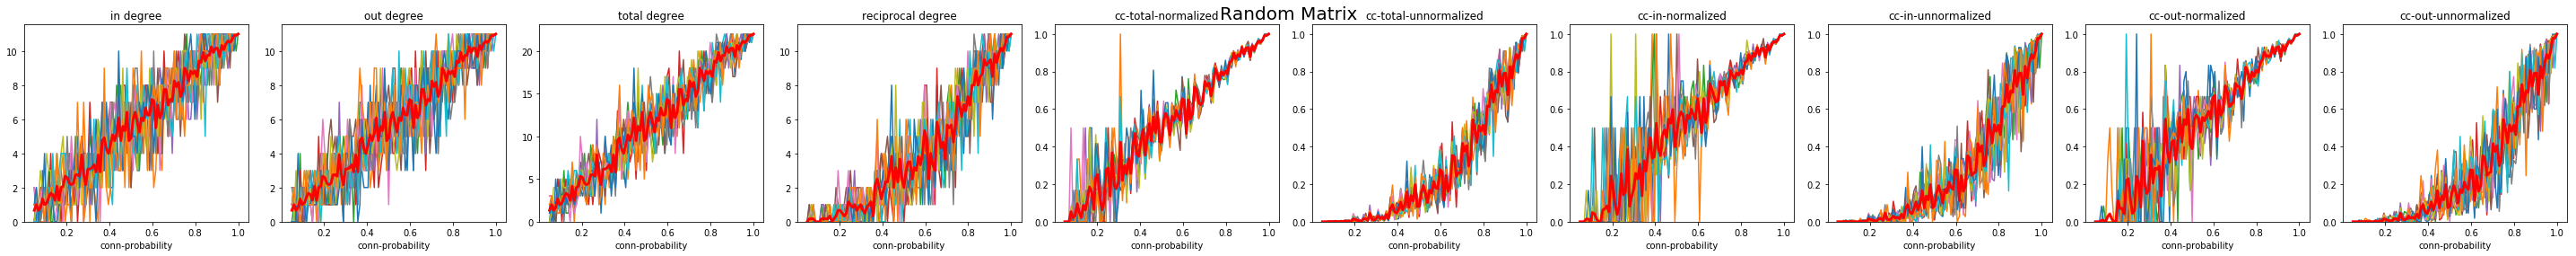

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


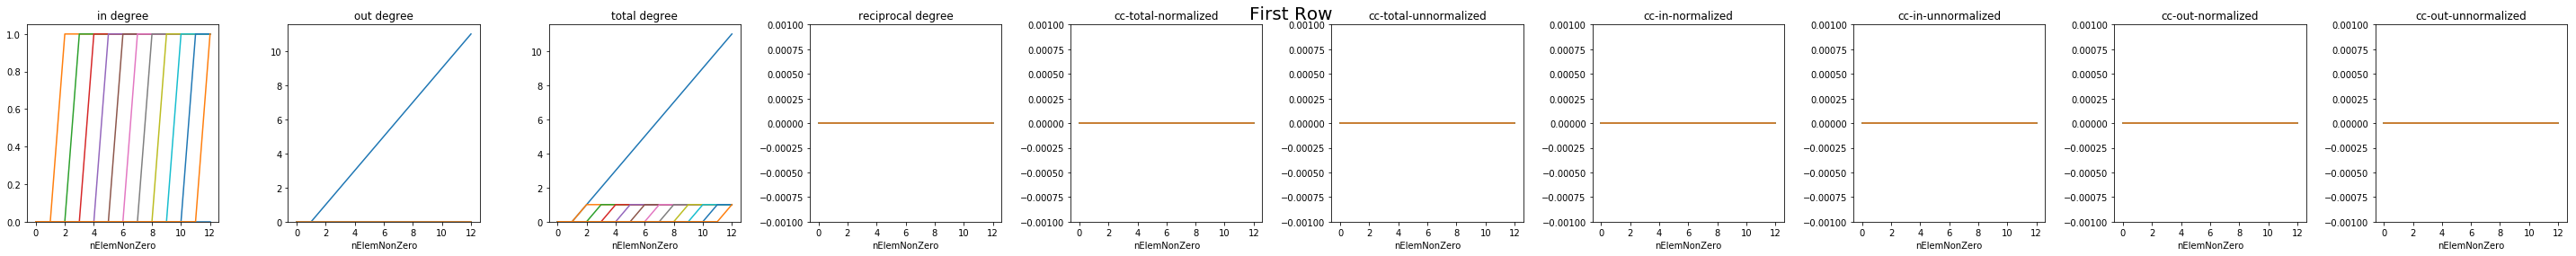

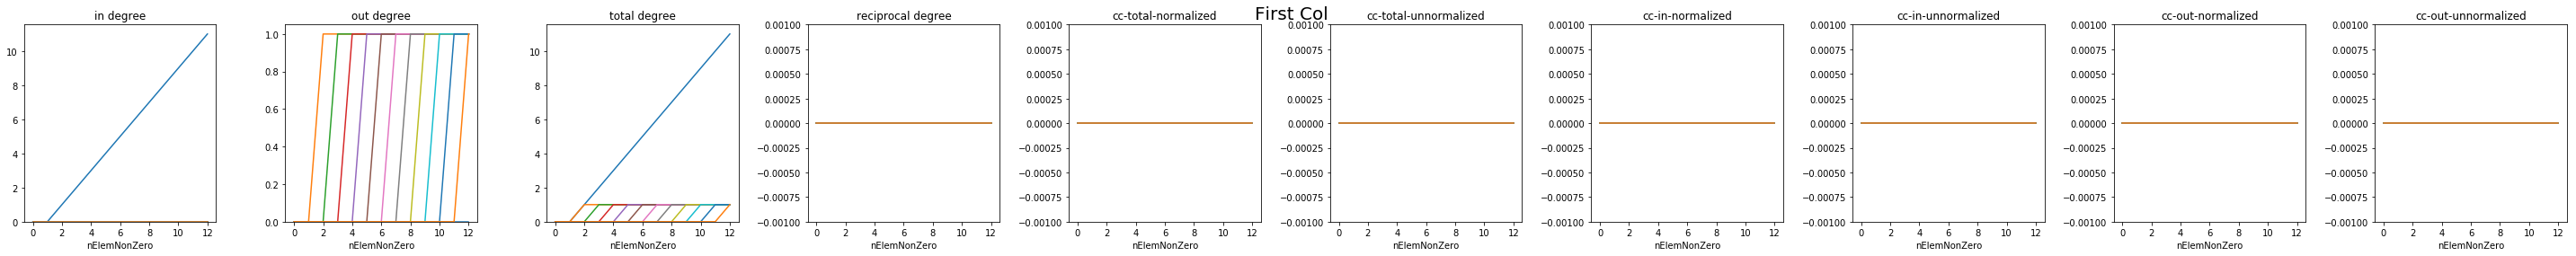

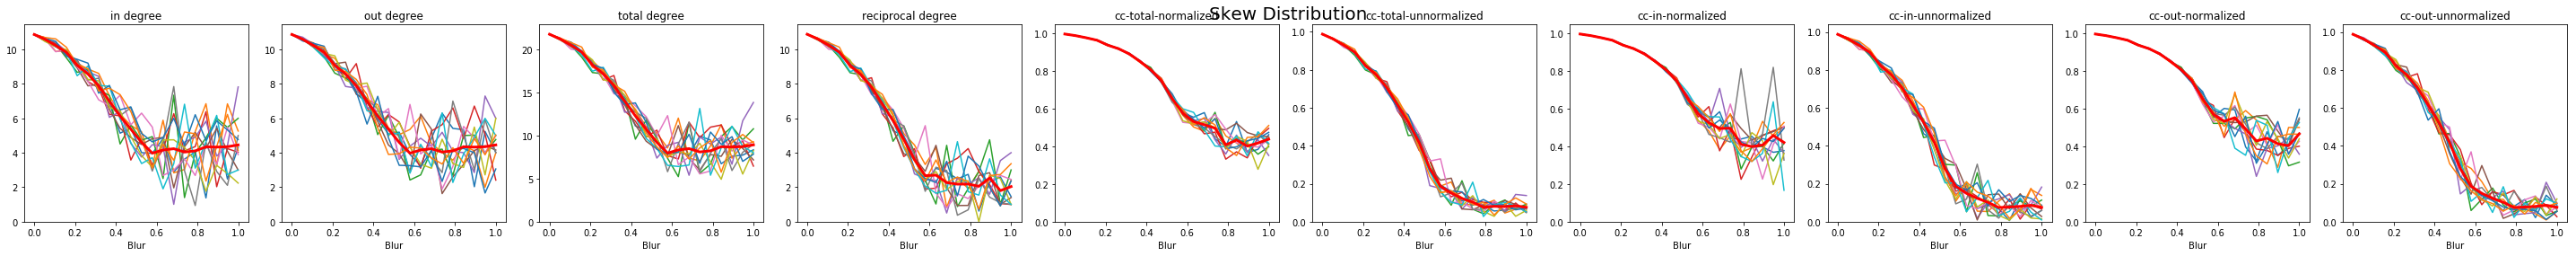

CPU times: user 5.2 s, sys: 1.81 s, total: 7.01 s
Wall time: 3.28 s


In [4]:
%%time
cc_tot_norm   = lambda M: graph_lib.cl_coeff(M, kind='tot', normDegree=True)
cc_tot_nonorm = lambda M: graph_lib.cl_coeff(M, kind='tot', normDegree=False)
cc_in_norm    = lambda M: graph_lib.cl_coeff(M, kind='in', normDegree=True)
cc_in_nonorm  = lambda M: graph_lib.cl_coeff(M, kind='in', normDegree=False)
cc_out_norm   = lambda M: graph_lib.cl_coeff(M, kind='out', normDegree=True)
cc_out_nonorm = lambda M: graph_lib.cl_coeff(M, kind='out', normDegree=False)

# Number of nodes in a matrix
nNode = 12

#############################
# List all tests to run
#############################
testFrame = pd.DataFrame({
    "Title"  : ["Random Matrix", "First Row", "First Col", "Skew Distribution"],
    "Func" : [randconn, fill1row, fill1col, skewdistr04],
    "PlotMean" : [True, False, False, True],
    "RangeName" : ["conn-probability", "nElemNonZero", "nElemNonZero", "Blur"],
    "Range" : [
        np.linspace(0.05, 1, 100),
        np.arange(0, nNode+1),
        np.arange(0, nNode+1),
        np.linspace(0, 1, 20),
    ]
})
nTest = len(testFrame["Title"])

#############################
# List all metrics to be evaluated
#############################
taskFrame = pd.DataFrame({
    "Name" : [
        'in degree',
        'out degree',
        'total degree',
        'reciprocal degree',
        'cc-total-normalized',
        'cc-total-unnormalized',
        'cc-in-normalized',
        'cc-in-unnormalized',
        'cc-out-normalized',
        'cc-out-unnormalized'],
    "Func" : [
        graph_lib.degree_in,
        graph_lib.degree_out,
        graph_lib.degree_tot,
        graph_lib.degree_rec,
        cc_tot_norm,
        cc_tot_nonorm,
        cc_in_norm,
        cc_in_nonorm,
        cc_out_norm,
        cc_out_nonorm]})
nTask = len(taskFrame["Name"])

for iTest in range(nTest):
    testfunc  = testFrame["Func"][iTest]
    testrange = testFrame["Range"][iTest]
    testrangename = testFrame["RangeName"][iTest]
    testplotmean = testFrame["PlotMean"][iTest]
    
    #############################
    # Compute different metrics for random matrices
    #############################
    nTrial = len(testrange)
    data = np.zeros((nTask, nTrial, nNode))
    for iTrial in range(nTrial):
        M = testfunc(nNode, testrange[iTrial])
        for iTask in range(nTask):
            data[iTask, iTrial] = taskFrame["Func"][iTask](M)

    #############################
    # Plot these metrics
    #############################
    fig, ax = plt.subplots(ncols=nTask, figsize=(4*nTask, 4), tight_layout=True)
    fig.suptitle(testFrame["Title"][iTest], fontsize=20)
    for iTask in range(nTask):
        ax[iTask].set_xlabel(testrangename)
        ax[iTask].set_ylim([0, 1.05 * np.max(data[iTask])])
        ax[iTask].set_title(taskFrame["Name"][iTask])
        ax[iTask].plot(testrange, data[iTask])
        if testplotmean:
            ax[iTask].plot(testrange, np.mean(data[iTask], axis=1), 'r', linewidth=3)
    plt.show()

## TODO:
1. Normalize matrix, not normalize matrix, or both?